In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import struct
%matplotlib widget

Creates initial random data in frequency domain. N is the max number of samples, while M is the samples being populated with random data

In [1]:
# N = 64 # NUmber of samples in the waveform, user defined
# N = 256 # Close, gives 14 or 15 spikes in bandpass
N = 256  
Nbits = 14
T = 16
### Above values were used for deployment 4, results in a spike at every 16th channel, about 4 MHz

def gen_flat_spectrum_waveform(N=64, band_fraction=2, seed=0):
    """
    Return a waveform with hermitian spectrum with random phases and unity amplitude
    """
    # M = (N//2)-1 # number of noise samples to draw
    M = (N//(2*band_fraction))-1 # number of noise samples to draw
    
    d_tilda = np.zeros(N) + 1j*np.zeros(N)
    # print(d_tilda.shape)
    
    np.random.seed(seed)
    dM_tilda =   np.exp(1j*np.random.uniform(0, 2*np.pi, size=M))
    conj_dM = np.conjugate(dM_tilda)[::-1]
    # print(dM_tilda.shape , conj_dM.shape)
    # print(d_tilda[1:M+1].shape)
    d_tilda[1:M+1] = dM_tilda
    d_tilda[-M:] = conj_dM
    d = np.fft.ifft(d_tilda)
    return d.real

def round_waveform(d, nbits=14, scale=1.0):
    d_scale = scale * d.real / np.max(np.abs(d.real)) * (2**(nbits - 1) - 1)
    #d_int = np.floor(d_scale).astype(int)
    #remainder = d_scale - d_int
    #odd = d_int % 1
    #do_round = np.where(remainder > 0.5, 1, np.where(remainder < 0.5, 0, odd))
    #d_int += do_round
    d_int = np.round(d_scale)
    return d_int.astype(int)

def tile_waveform(d, T=16):
    d_repeat = np.tile(d, T)
    return d_repeat

def pack_waveform(d_repeat):
    d_pack = d_repeat * 4
    pr = struct.pack(f'>{d_pack.size}h', *d_pack)
    return pr

def max_addr_calc(N=64, T=16):
    return int((N*T/4) - 3)

### Finding Best Seed for Uniform Spikes

Don't run!!!

816343 2.0100859204113696e-10
-3.0357660829594124e-18 0.046875


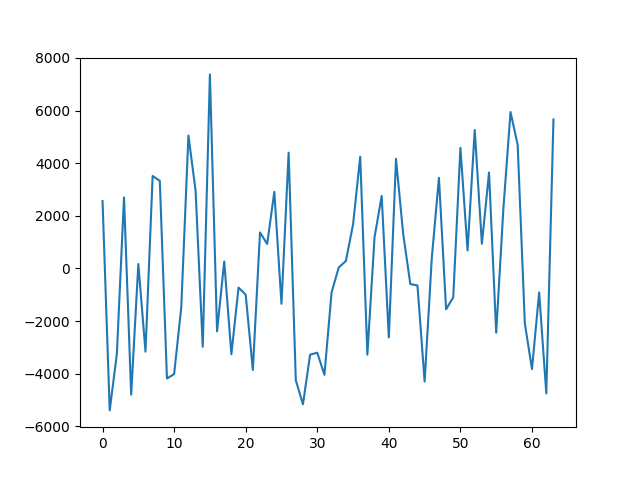

In [126]:
goal_spec = np.zeros_like(repeat_fft)
goal_spec[T::T] = 1
goal_spec[N*T//2] = 0

best_seed = 152063
best = 2.1635e-10
for seed in range(200000, 2000000):
    d = gen_flat_spectrum_waveform(N, seed=seed)
    d_back = np.fft.fft(d)
    d_int = round_waveform(d, nbits=Nbits, scale=.9)
    d_repeat = tile_waveform(d_int, T)
    repeat_fft = np.fft.fft(d_repeat)
    p_spec = np.abs(repeat_fft)**2
    peak = np.mean(p_spec[T:12*T:T])
    p_spec /= peak
    score = np.mean(np.abs(p_spec - goal_spec)**2)
    if score < best:
        print(seed, score)
        best = score
#peak = 1
print(np.mean(d), np.mean(d_int))

plt.figure()
# plt.plot(d.real)
# plt.plot(d.imag)
plt.plot(d_int.real)
# plt.plot(d_int.imag)
# plt.plot(freq, np.fft.fftshift(np.abs(d_tilda)))
# plt.plot(freq, np.fft.fftshift(np.abs(d_back)), linestyle='--')
# plt.plot(freq, np.abs(np.fft.fftshift(d_tilda)))
plt.show()

### Using Best Seed: 816343

In [4]:
better_seed = 816343

d = gen_flat_spectrum_waveform(N, seed=better_seed)
d_back = np.fft.fft(d)
d_int = round_waveform(d, nbits=Nbits, scale=.9)
d_repeat = tile_waveform(d_int, T)
d_pack = pack_waveform(d_repeat)

Amount of Peaks: 63


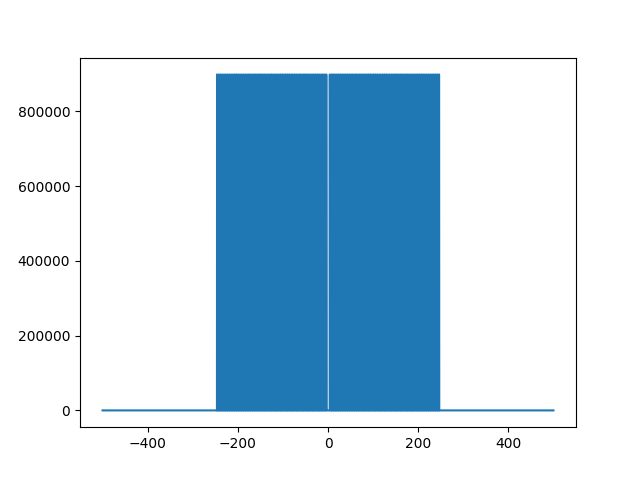

In [5]:
d_fft = np.fft.fft(d_repeat)
peak_num = int(np.where(np.abs(d_fft) > 50000)[0].shape[0])
print('Amount of Peaks:', int(peak_num/2))
freqs = np.fft.fftfreq(d_fft.size, 1/(1000e6))

plt.figure()
plt.plot(np.fft.fftshift(freqs)/1e6, np.fft.fftshift(np.abs(d_fft)))
plt.show()

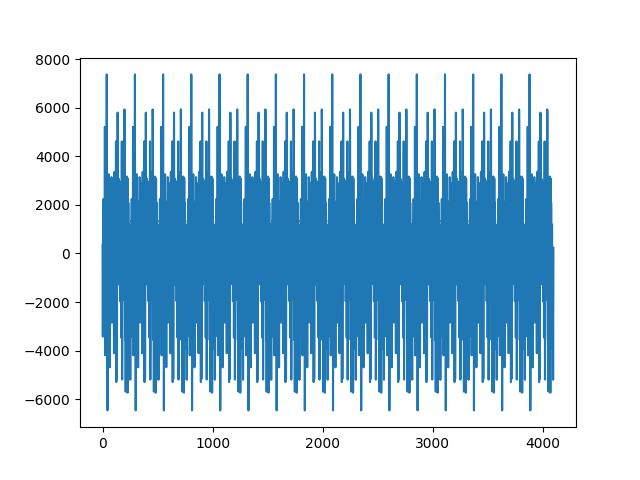

373 234


In [6]:
plt.figure()
plt.plot(d_repeat)
plt.show()
print(d_repeat[0], d_repeat[-1])

In [7]:
# max_addr = 8189
# max_addr = 61 * 2
# print(max_addr_calc(N, T))
# max_addr = 125

max_addr = max_addr_calc(N, T)
print(max_addr)

1021


In [27]:
np.savez(f'/home/dominiv/simulink/rfsoc2x2/16_mhz_attempt.npz', data=d_repeat, max_addr = np.array(max_addr))